# Analyzing Northeast Atlantic Fishing Data from 1903-2018
Parker Tewell
## Outline
1. Introduction
2. Data Collection
3. Data Manipulation
4. Exploratory Data Analysis
5. Conclusion

# Introduction
Every year our global fish stocks get depleted further and further with no time to regenerate. It was (more) common to catch fish 50 years ago that were as big as a man, but now those same species caught are only a fraction of the size. This unfortunately is due to overfishing, fish that were once able to live full lives are snatched out of the ocean before reaching maturity. And without mature fish to breed, a species can easily die out. For this project I'll be taking a look at data collected from FAO major fishing area 27. (FAO stands for Food and Agriculture Organization and is an agency of the UN). By analyzing this data I hope to find trends in the way we consume/harvest fish in order to better understand overfishing and why it might happen.

Data Information:
The three data sets I use span over three time periods, 1903-1949, 1950-2010, and 2006-2018. The data includes species caught, landings (which is essentially the amount of fish caught in tonnes), country, and area. Further information can be found [here](https://gis.ices.dk/geonetwork/srv/api/records/7d242743-1069-417b-81e3-57f25c791a26).

# Data Collection

In [1]:
# Importing the libraries I'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
# Importing the data
# All locations correspond to: Northeast Atlantic, FAO Area 27
landings1903_1949 = pd.read_excel("1903-1949_Landings.xlsx")
landings1950_2010 = pd.read_excel("ICES_1950-2010.xls")
landings2006_2018 = pd.read_excel("ICESCatchDataset2006-2018.xlsx",sheet_name=1)

# Data Tidying

While importing my data was painless, combining my datasets won't be. All three of my datasets have different naming and storage schemes, so I'm going to have to do a lot of tedious renaming and refactoring in order to get the data in a form that is workable.

In [3]:
# Tidying the data
# Currently the all of the datasets have different formats, so I'll transform them into a standard form
# The first thing I'm going to do is get the data into one dataframe
# I want to combine on year, country, and area so I'm going to drop species data I might analyze fish species later

landings1903_1949.drop(columns=["Species scientific name", "FAO_Species_Name", "FAO_Species_Code"], inplace=True)
landings1950_2010.drop(columns=["Species"], inplace=True)
landings2006_2018.drop(columns=["Species","Units"], inplace=True) 

In [4]:
# Transforming landings1903_1949
# Fill in missing data with 0
landings1903_1949.replace(['-',':'], 0, inplace=True)
landings1903_1949.replace(r'^\s*$', 0, regex=True, inplace=True)
landings1903_1949.replace(['P','p'], 0.5, inplace=True)

# Combine rows to get rid of species seperation
landings1903_1949 = landings1903_1949.groupby(['Year','Country','FAO_Area'])['Landings'].sum().reset_index()

In [5]:
# Right now each year is a row, but I want them as columns
# So I'll make a new dataframe with the years as columns for each row
standardized_landings1903_1949 = landings1903_1949.copy(deep=True)
standardized_landings1903_1949.drop(columns=['Landings','Year'], inplace=True)

for year in pd.unique(landings1903_1949["Year"]):
    standardized_landings1903_1949[year] = np.nan

for index, row in landings1903_1949.iterrows():
    standardized_landings1903_1949.loc[(standardized_landings1903_1949['Country'] == row['Country']) & (standardized_landings1903_1949['FAO_Area'] == row['FAO_Area']), [row['Year']]] = row['Year']

landings1903_1949 = standardized_landings1903_1949

In [6]:
# Next I need to rename columns and countries so everything is uniform
landings2006_2018.rename(columns={'Area':'FAO_Area'},inplace=True)
landings1950_2010.rename(columns={'Division':'FAO_Area'},inplace=True)
landings1950_2010.drop(columns=[2006, 2007, 2008, 2009, 2010], inplace=True)
landings1950_2010.drop(landings1950_2010[landings1950_2010['Country'] == 'Other nei'].index, inplace = True)

In [7]:
# I need to standardize the countries into their 3-character country codes
# Unfortunately for me every dataset uses a different naming scheme
# Note that I'm grouping English channel islands and regions within the British Isles with Great Britian
country_codes = {'Belgium':'BEL', 'Bulgaria':'BGR', 'Cape Verde':'CPV', 'Channel Is.- Guernsey':'GBR', 
'Channel Is.- Jersey':'GBR', 'Channel Islands (ns)':'GBR','China':'CHN', 'Denmark':'DNK', 'Estonia':'EST', 
'Faeroe Islands':'DNK', 'Finland':'FIN', 'France':'FRA', 'Germany':'DEU', 'Germany, Fed. Rep. of':'DEU', 
'Germany, New Länder':'DEU', 'Greenland':'GRL', 'Iceland':'ISL', 'Ireland':'IRL', 'Isle of Man':'GBR', 
'Italy':'ITA', 'Japan':'JPN', 'Korea, Republic of':'KOR', 'Latvia':'LVA', 'Libyan Arab Jamahiriya':'LBY', 
'Lithuania':'LTU', 'Netherlands':'NLD','Norway':'NOR', 'Panama':'PAN', 'Poland':'POL', 'Portugal':'PRT',
'Romania':'ROU', 'Russian Federation':'RUS', 'Spain':'ESP','Svalbard and Jan Mayen':'NOR', 'Sweden':'SWE',
'Taiwan Province of China':'TWN','UK - Eng+Wales+N.Irl.':'GBR','UK - England & Wales':'GBR',
'UK - N. Ireland':'GBR','UK - Scotland':'GBR','Ukraine':'UKR','Un. Sov. Soc. Rep.':'RUS', 
'United States of America':'USA'}

two_three_codes = {'DK':'DNK', 'EE':'EST', 'LT':'LTU', 'LV':'LVA', 'NL':'NLD', 'PL':'POL', 
'RU':'RUS', 'IE':'IRL', 'JE':'GBR', 'PT':'PRT', 'ES':'ESP', 'SE':'SWE', 'NO':'NOR', 'DE':'DEU', 
'GB':'GBR', 'FR':'FRA', 'CN':'CHN', 'JP':'JPN', 'KR':'KOR', 'TW':'TWN', 'IS':'ISL', 'FO':'DNK',
'BE':'BEL', 'IM':'GBR', 'GL':'GRL', 'GG':'GBR', 'FI':'FIN'}

territory_codes = {'GBU':'GBR','GBS':'GBR','GBE':'GBR','FRO':'DNK'}

landings1903_1949.replace(territory_codes, inplace=True)
landings1950_2010.replace(country_codes, inplace=True)
landings2006_2018.replace(two_three_codes, inplace=True)

In [8]:
# Now I also need to standardize the locations
# Once again they're all different
# I'm ignoring any sub area designated with a number since
# they don't factor into my analysis at all
# I just care about the general areas
# Also I know all my data comes from FAO area 27, so I can drop the 27 prefix
# I am going to ignore data that stretches over multiple areas, since I have no knowledge of 
# how the landings are distributed between the two

roman_to_modern = {'IIIa':3, 'IIIb-d':3,'IV':4, 'IX':9, 'UNK':np.nan, 'VI':6, 'Va':5, 
'Vb':5, 'VII':7, 'VIa':6, 'VIIa':7, 'VIIb-k':7, 'I':1, 'IIa':2, 'VIId,e':7, 'VIIg-k':7, 
'VIII':8, 'VIIb,c,g-k':7, 'VIIf':7, 'VIb':6, 'VIIb,c':7, 'VIIa,f':7, 'IIIa,IV':3, 
'IIIc':3, 'IIId':3, 'IXa':9, 'IIIa,b':3, 'IVb':4, 'IVa':4, 'IVa,b':4, 'IVb,c':4, 
'IVc':4, 'IIb':2, 'IIIb,d':3, 'VIIIa,b':8, 'IIIc,d':3, 'VIIIa':8,
'VIIa,d,e':7, 'IIIa,c':3, 'IIIa-c':3, 'Va ':5, 'UNK ':np.nan, 'XIV':14,
'III':3, 'IIIa,c,d':3, 'Va_SW':5, 'Va_NE':5, 'IIIb':3, 'IV b':4, 'IV c':4, 'VII a':7, 
'VII b':7, 'VII d':7, 'VII e':7, 'VII f':7, 'VII g':7, 'VII h':7, 'VIII a':8, 
'VIII b':8, 'IV (not specified)':4, 'IV a':4, 'V a (not specified)':5, 
'V a (South-West)':5, 'VI a':6, 'VII a-f  (not specified)':7, 'VII d+e (not specified)':7,
'VII g-k  (not specified)':7, 'I (not specified)':1, 'ICES Area (not specified)':np.nan, 
'II b (not specified)':2, 'III a':3, 'V b1 (not specified)':5, 'VI b (not specified)':6,
'VII j (not specified)':7, 'VIII (not specified)':8, 'III d  (not specified)':3, 
'III b  Baltic 23':3, 'III c  Baltic 22':3, 'III d  Baltic 24':3, 'II a (not specified)':2, 
'II a2':2, 'III b+c (not specified)':3, 'IV a+b (not specified)':4, 'V b (not specified)':5, 
'III d  Baltic 25':3, 'III d  Baltic 26':3, 'III d  Baltic 27':3, 'III d  Baltic 28 (not specified)':3,
'III d  Baltic 29':3, 'IX (not specified)':9, 'VI (not specified)':6,'VII b+c  (not specified)':7, 
'VIII d (not specified)':8, 'XIV b (not specified)':14, 'V b1B':5, 'XIV a':14, 'IV,VII':np.nan,
'VII c (not specified)':7, 'VII j2':7, 'VIII d2':8, 'IX a':9, 'IX b (not specified)':9, 
'V b2':5, 'VI b2':6, 'VII c2':7, 'XII (not specified)':12, 'XIV (not specified)':14,
'III d  Baltic 32':3, 'XIV b2':14, 'III d  Baltic 28-1':3, 'III d  Baltic 28-2':3, 
'VII k (not specified)':7, 'I a':1, 'I b':1, 'II b1':2, 'X (not specified)':10, 
'III d  Baltic 30':3, 'III d  Baltic 31':3, 'VII (not specified)':7, 'VIII c':8,
'VIII e (not specified)':8, 'X a (not specified)':10, 'XII a (not specified)':12, 
'II (not specified)':2, 'V (not specified)':5, 'II a1':2, 'VI b1':6, 'VII c1':7, 'VII j1':7,
'VII k1':7, 'VIII d1':8, 'V b1A':5, 'IX b1':9, 'XII a1':12, 'V a1':5, 'V a (North-East)':5,
'III b-d (not specified)':3, 'VII d-k (not specified)':7, 'IIIa,IVc':np.nan,
'V a+b1  (not specified)':5, 'XIV b1':14, 'IIIa  and  IV  (not specified)':np.nan,
'XII a3':12, 'II b2':2, 'VII f-k  (not specified)':12, 'I  and  IIa (not specified)':np.nan,
'VII k2':12, 'IV b+c (not specified)':4, 'V a2':5, 'XII b':12, 'X b':10, 'VIII e1':8, 
'VIII e2':8, 'IX b2':9, 'III (not specified)':3, 'IIIa  and  IVa+b  (not specified)':np.nan}

long_to_short = {'27':np.nan, '27.3':3, '27.3.a':3, '27.3.c.22':3, '27.4':4, 
'27.4.b':4, '27.3.d':3, '27.3.d.24':3, '27.3.d.25':3, '27.3.d.26':3, 
'27.3.d.28':3, '27.3.d.28.1':3, '27.3.d.28.2':3, '27.3.d.28_NK':3, 
'27.3.d.29':3, '27.3.d.32':3, '27.4.c':4, '27.10':10, '27.10.a':10, 
'27.10.a.1':10, '27.10.b':10, '27.7':7, '27.7.e':7, '27.7.j':7, 
'27.7.j_NK':7, '27.9':9, '27.9.a':9, '27.9.b':9, '27.9.b.1':9, '27.3.d.31':3, 
'27.3.d_NK':3, '27.4.a':4, '27.3.a.20':3, '27.7.a':7, '27.8':8, '27.8.c':8, 
'27.10.a.2':10, '27.10.a_NK':10, '27.10_NK':10, '27.2':2, '27.2.b':2,
'27.2.b_NK':2, '27.6':6, '27.6.a':6, '27.7.b':7, '27.7.c':7, '27.7.c_NK':7,
'27.7.d':7, '27.7.f':7, '27.7.g':7, '27.7.h':7, '27.7.k':7, '27.7.k_NK':7,
'27.8.a':8, '27.8.b':8, '27.8_NK':8, '27_NK':np.nan, '27.9_NK':9, '27.1':1,
'27.1_NK':1, '27.12':12, '27.12.a':12, '27.12.a.1':12, '27.12.a.2':12,
'27.12.a.3':12, '27.12.a.4':12, '27.12.a_NK':12, '27.12.b':12, '27.12.c':12,
'27.12_NK':12, '27.14':14, '27.14.a':14, '27.14.b':14, '27.14.b_NK':14, 
'27.5':5, '27.5.b':5, '27.5.b_NK':5, '27.6.b':6, '27.6.b.1':6, '27.6.b.2':6,
'27.6.b_NK':6, '27.7.c.1':7, '27.7.c.2':7, '27.7.j.1':7, '27.7.j.2':7,
'27.7.k.1':7, '27.7.k.2':7, '27.7_NK':7, '27.8.d':8, '27.8.d.1':8,
'27.8.d.2':8, '27.8.d_NK':8, '27.8.e':8, '27.8.e.1':8, '27.8.e.2':8,
'27.8.e_NK':8, '27.9.b.2':9, '27.9.b_NK':9, '27.14.b.2':14, '27.14_NK':14,
'27.5.a':5, '27.5.a.1':5, '27.5.a.2':5, '27.5.a_NK':5, '27.5.b.1':5,
'27.5.b.1_NK':5, '27.6_NK':6, '27.2.a':2, '27.2.a.2':2, '27.3.a.21':3,
'27.3.a_NK':3, '27.3.d.27':3, '27.3.d.30':3, '27.4_NK':4, '27.1.b':1,
'27.2.a.1':2, '27.2.a_NK':2, '27.5.b.1.b':5, '27.5.b.2':5, '27.14.b.1':14,
'27.2.b.2':2, '27.5.b.1.a':5, '27.3.b.23':3, '27.7.bc_NK':7, '27.1.a':1,
'27.2.b.1':2, '27.2_NK':2, '27.5_NK':5, '27.3_NK':3, '27.7.g-k_NK':7,
'27.5.b.2_NK':5}

landings1903_1949.replace(roman_to_modern, inplace=True)
landings1950_2010.replace(roman_to_modern, inplace=True)
landings2006_2018.replace(long_to_short, inplace=True)

In [9]:
# Combining the three time periods
landings1903_2018 = pd.concat([landings1903_1949, landings1950_2010, landings2006_2018])

In [10]:
# I'm going to rearrange the columns so that they're in cronological order
# Note that I didn't type all these years out by hand, I just used list(columns.values)
columns = ['Country', 'FAO_Area', 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
landings1903_2018 = landings1903_2018[columns]

landings1903_2018.fillna(0,inplace=True)
landings1903_2018.replace(['c','.','-'], 0, inplace=True)
landings1903_2018.replace('<0.5', 0.5, inplace=True)

landings1903_2018

,Country,FAO_Area,1903,1904,1905,1906,1907,1908,1909,1910,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,DEU,3.0,1903.0,1904.0,1905.0,1906.0,1907.0,1908.0,1909.0,1910.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
1,DEU,3.0,1903.0,1904.0,0.0,0.0,1907.0,1908.0,1909.0,1910.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
2,DEU,4.0,1903.0,1904.0,1905.0,1906.0,1907.0,1908.0,1909.0,1910.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
3,DEU,9.0,1903.0,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
4,DEU,0.0,1903.0,1904.0,1905.0,1906.0,1907.0,1908.0,1909.0,1910.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55805,ESP,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.33,0.2,0.3,0.35,0.31,0.58
55806,ESP,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.33,0.2,0.3,0.35,0.31,0.58
55807,ESP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.54
55808,ESP,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.54


# Exploratory Data Analysis

So now that we've got our data in one place, we can finally play around with it, my main goal today is to find a way to explain the landings a country reports.

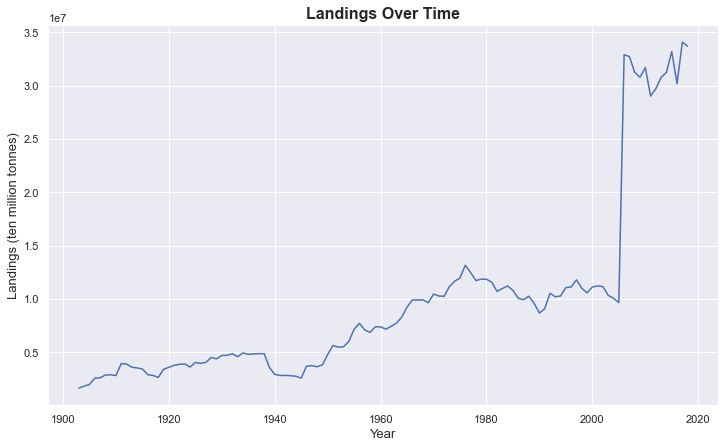

In [11]:
# EDA
# Now that I've got the data all formatted the same way, I can start my exploratory data analysis
# The first thing I'll do is compare the landings per decade to see if us humans are consuming more fish
# I'll also visualize these landings based on their area over time to see which regions are the most popular for fishing

# Create variables for graph
x = range(1903,2019)
y = []
for year in landings1903_2018:
    if year != 'Country' and year != 'FAO_Area':
        y.append(landings1903_2018[year].sum())
        
# Set the title and axes + some other stuff
sns.set_theme()
plt.figure(figsize=(12,7))
plt.title("Landings Over Time", fontsize = 16, fontweight = "bold")
plt.xlabel("Year", fontsize = 13)
plt.ylabel("Landings (ten million tonnes)", fontsize = 13)

# Plot
sns.lineplot(x=x,y=y)
plt.show()

From this plot we can initially observe fairly small increase of fishing over time by year with some noteable exceptions during the world wars (especially WW2). After the second world war the landings start growing faster until around 1980 which then shows a steady decline before the amount of fish caught nearly doubles in 2010! 

Is this due to a sudden demand for fish in 2010? Maybe, but this probably isn't the whole story. When I first imported the data I had three time periods of data, 1901-1949, 1950-2010, and 2006-2018. We can safely assume that as time progressed the reporting of fishing statistics got more and more accurate, meaing that this sudden increase in landings can be attributed to a rise in demand for seafood as well as an improvement in the methods used to collect such data.

Next I'll compare the landings between each country.

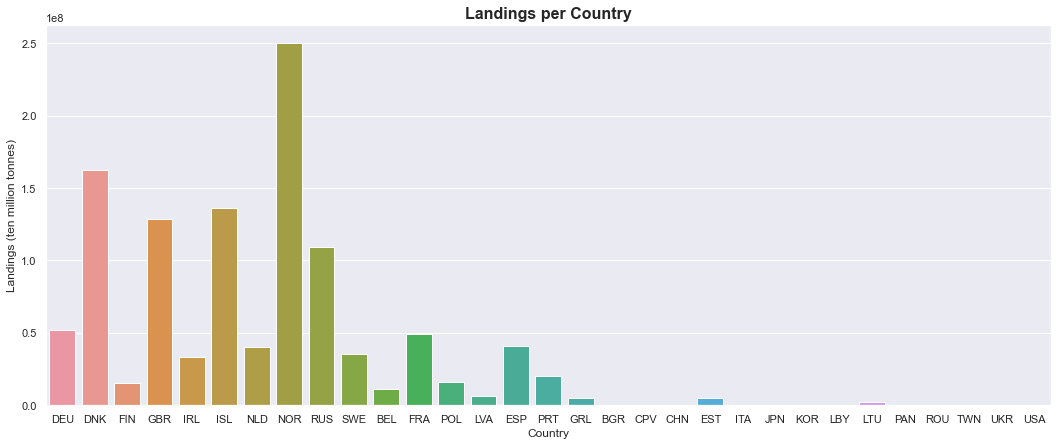

In [12]:
# Create variables for graph
country_landing_dict = dict.fromkeys(pd.unique(landings1903_2018['Country']),0)

for index, row in landings1903_2018.iterrows():
    country_landing_dict[row['Country']]+= row[2:].sum()

sum_landings = pd.DataFrame(list(country_landing_dict.items()),columns = ['Country','Landings']) 

# Plot
plt.figure(figsize=(18,7))
plt.title("Landings per Country", fontsize = 16, fontweight = "bold")
sns.barplot(x='Country', y='Landings', data=sum_landings).set(xlabel="Country", ylabel="Landings (ten million tonnes)")
plt.show()

From this plot we can see that Norway is the leader for fishing in the North East Atlantic. 
But we also have several 'dead' columns from countries outside of Europe. I'll ignore these countries when I compare countries later since they don't add much to my analysis. It also seems like Italy hasn't reported many landings in the North East Atlantic which makes sense since they're located in the Mediterranean, so it looks like I should really only account for European countires close to the North East Atlantic. Let's try and look at how these Atlantic Europeans compare to each other.

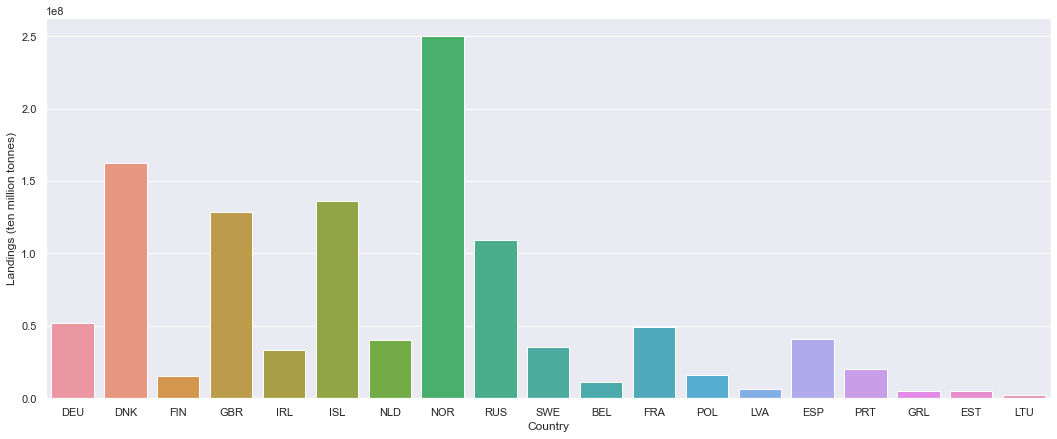

In [13]:
non_atlantic = ['CHN','JPN','KOR','LBY','PAN','TWN','USA','CPV','BGR','ROU','UKR','ITA']
landings1903_2018 = landings1903_2018[~landings1903_2018['Country'].isin(non_atlantic)]

for country in non_atlantic:
    country_landing_dict.pop(country)

sum_landings = pd.DataFrame(list(country_landing_dict.items()),columns = ['Country','Landings']) 

plt.figure(figsize=(18,7))
sns.barplot(x='Country', y='Landings', data=sum_landings).set(xlabel="Country", ylabel="Landings (ten million tonnes)")
plt.show()

Upon inspection it seems that countries that are islands/ mostly coastal collect more fish than other countries. This is pretty obvious but maybe there is a correlation between the length of a countries coastline and the amount of fish they catch? To do this I'll need to scrape coastline data off the web, wikipedia has a pretty extensive list so I'll grab my coastlines from there.

In [15]:
%%capture
# Suppressing warnings because this cell has a lot of them
# Grabbing wikipedia data
wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline')[0]

# Creating a country to coastline map, I need to run the country names through my previous name 
# to code dictionary I created earlier
# I'll be using the coastlines detailed in the World Factbook since it is more extensive
# Note that the CIA world factbook did not specify what interval they used to
# measure the coasts or if they even used the same interval to measure all of them 
# But hopefully the CIA was consistent and is just being secretive
# (The reason interval really matters is the coastline paradox)

coast_dict = dict(zip(wiki_table['Country','Country'],wiki_table[('The World Factbook[2]','km')]))

# Renaming non-conformant names
coast_dict['Greenland'] = coast_dict.pop('Greenland[Note 3]')
coast_dict['Ireland'] = coast_dict.pop('Republic of Ireland')
coast_dict['Spain'] = coast_dict.pop('Spain[Note 5]')

# Adding the coast data to my FAO dataset(s)
landings1903_2018['coastline'] = 0
sum_landings['coastline'] = 0

# Codes to names
atlantic_codes = {'BEL':'Belgium', 'DNK':'Denmark', 'EST':'Estonia', 'NLD':'Netherlands',
'FIN':'Finland', 'FRA':'France', 'DEU':'Germany', 'GRL':'Greenland', 'ISL':'Iceland', 
'IRL':'Ireland', 'GBR':'United Kingdom', 'LVA':'Latvia', 'LTU':'Lithuania', 
'Netherlands':'NLD','NOR':'Norway', 'Panama':'PAN', 'POL':'Poland', 'PRT':'Portugal', 
'RUS':'Russia', 'ESP':'Spain', 'SWE':'Sweden'}

# Need to convert from name to code
for index, row in landings1903_2018.iterrows():
    landings1903_2018.loc[index, 'coastline'] = coast_dict[atlantic_codes[row['Country']]]
    
for index, row in sum_landings.iterrows():
    sum_landings.loc[index, 'coastline'] = coast_dict[atlantic_codes[row['Country']]]
    
# Need to get rid of the notes from the wiki page
coast_corrections = {'83,281[4]':'83,281','37,653[Note 4]':'37,653','451[Note 10]':'451'}
landings1903_2018.replace(coast_corrections, inplace=True)
sum_landings.replace(coast_corrections, inplace=True)

# Cast strings to floats
for index, row in sum_landings.iterrows():
    sum_landings.loc[index, 'coastline'] = row['coastline'].replace(',', '')
sum_landings['coastline'] = pd.to_numeric(sum_landings['coastline'])

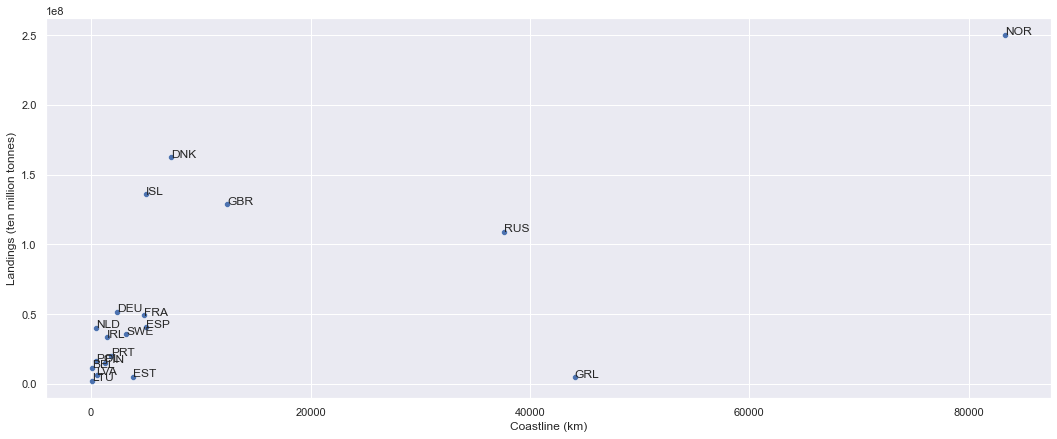

In [16]:
# First I just need to add coastlines to my sum_landings dataframe
plt.figure(figsize=(18,7))
ax = sns.scatterplot(x='coastline', y='Landings',data=sum_landings).set(xlabel="Coastline (km)", ylabel="Landings (ten million tonnes)")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(sum_landings.coastline, sum_landings.Landings, sum_landings.Country, plt.gca()) 

plt.show()

This plot looks somewhat linear, but maybe we can add more variables to see if a stronger relationship forms. Perhaps population also plays a factor in landings? Having a coast doesn't matter if you don't have people to exploit it! Once again I'll get my population figures from Wikipedia using the same method I used before.

In [17]:
# Importing population data from wikipedia
# I've done this before so it's not too hard a second time
wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population')[0]
pop_dict = dict(zip(wiki_table['Country(or dependent territory)'],wiki_table[('Population')]))

# Get rid of the notes from the wiki page
pop_dict['Greenland'] = pop_dict.pop('Greenland (Denmark)')
pop_dict['Russia'] = pop_dict.pop('Russia[f]')
pop_dict['United Kingdom'] = pop_dict.pop('United Kingdom[h]')
pop_dict['Finland'] = pop_dict.pop('Finland[q]')
pop_dict['Denmark'] = pop_dict.pop('Denmark[p]')
pop_dict['Netherlands'] = pop_dict.pop('Netherlands[m]')
pop_dict['France'] = pop_dict.pop('France[g]')

# Create and populate population column
sum_landings['population'] = 0

for index, row in sum_landings.iterrows():
    sum_landings.loc[index, 'population'] = pop_dict[atlantic_codes[row['Country']]]
sum_landings

,Country,Landings,coastline,population
0,DEU,5.187001e+07,2389.0,83190556
1,DNK,1.626500e+08,7314.0,5843347
2,FIN,1.512592e+07,1250.0,5506915
3,GBR,1.288619e+08,12429.0,66796807
4,IRL,3.339048e+07,1448.0,4977400
5,ISL,1.360959e+08,4970.0,369870
6,NLD,4.013921e+07,451.0,17593831
7,NOR,2.501972e+08,83281.0,5391369
8,RUS,1.089723e+08,37653.0,146171015
9,SWE,3.563742e+07,3218.0,10389806


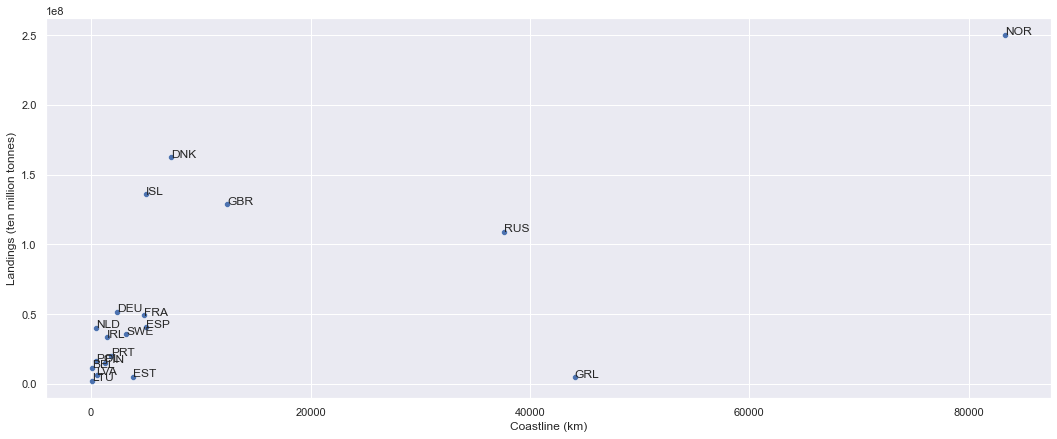

In [18]:
plt.figure(figsize=(18,7))
label_point(sum_landings.coastline, sum_landings.Landings, sum_landings.Country, plt.gca()) 
sns.scatterplot(x='coastline', y='Landings',data=sum_landings).set(xlabel="Coastline (km)", ylabel="Landings (ten million tonnes)")
plt.show()

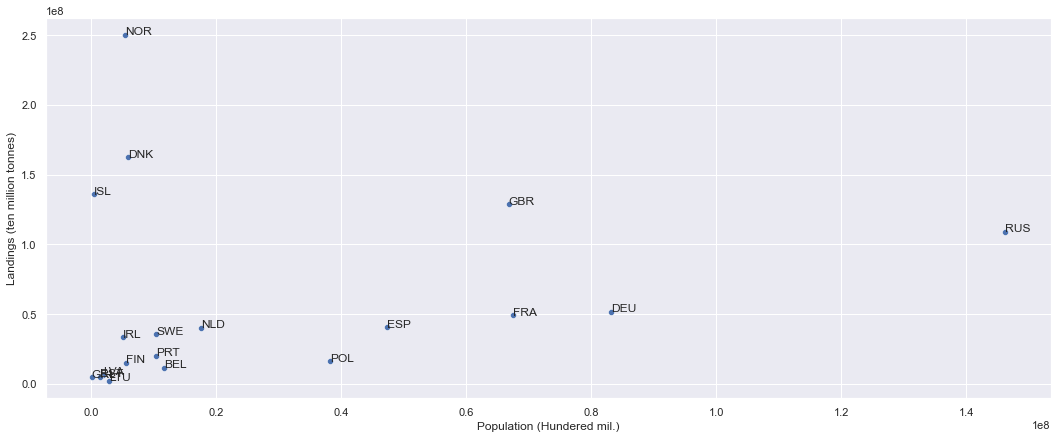

In [19]:
# Plotting my landings with population
plt.figure(figsize=(18,7))
label_point(sum_landings.population, sum_landings.Landings, sum_landings.Country, plt.gca()) 
sns.scatterplot(x='population', y='Landings',data=sum_landings).set(xlabel="Population (Hundered mil.)", ylabel="Landings (ten million tonnes)")
plt.show()

This plot also shows a slight linear correlation between population and landings, I'm confident now that we will probably be able to establish a linear model between landings and coastline + population. Although I am not going to add an interaction between population and coastline since I don't believe having a large coast means you will have a large population. While water is good for civilization, coastal waters don't include rivers and lakes. So I wouldn't be comfortable adding an interaction term unless all water in a country was accounted for.

# Step 4 Hypothesis Testing
Now that we've indentified a hypothesis, let's test it:\
Ho: We cannot predict landings based on population and coast length\
Ha: We can predict landings based on population and coast length

In order to run a linear regression on my data, I need to check a few assumptions:
1. There is an underlying linear relationship between landings and coast length and population
2. The residuals are independent of each other. (There is no relationship between residuals and landings)
3. Constant variation (The variance of the residuals is the same for all values)
4. Residuals are normally distributed (Self-explanatory)

I already know our 1st assumption is valid due to our previous scatterplots. Now I need to test our residuals for independence and normality

In [20]:
# Getting our linear model
# I need to first calculate my linear model in order to calculate my residuals
lr = linear_model.LinearRegression()
X = sum_landings[['coastline','population']]
Y = sum_landings['Landings']
lr.fit(X,Y)

intercept=lr.intercept_
coefficients=lr.coef_

print('Regression Equation:')
print('y = ' + str(intercept) + ' + (' + str(coefficients[0]) + ' * x1) + ' + '(' + str(coefficients[1]) + ' * x2)')

Regression Equation:
y = 31748938.80398237 + (2018.4850724529213 * x1) + (0.155409678047135 * x2)


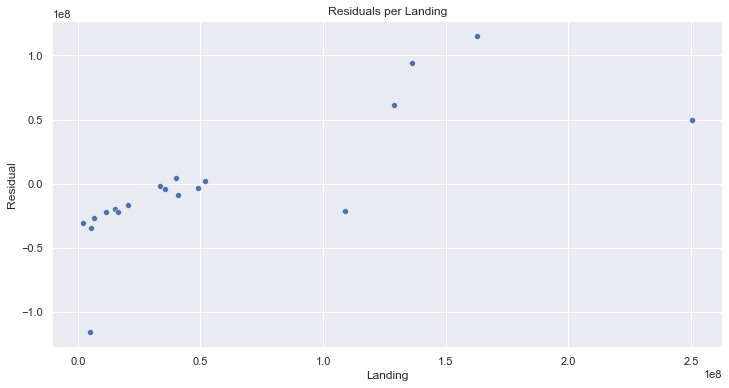

In [21]:
# Plotting the residuals
sum_landings['residual'] = sum_landings['Landings'] - ((coefficients[0]*sum_landings['coastline']) + (coefficients[1]*sum_landings['population']) + intercept)

# Plot the residuals
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Landings", y="residual", data=sum_landings)
plt.title("Residuals per Landing")
plt.xlabel("Landing")
plt.ylabel("Residual")
plt.show()

From my scatterplot of residuals I can see that they don't seem to be dependent on the landings (The residuals are fairly balanced over the middle of the plot, although it does seem like the residuals lean more positive as landings increase, I can also observe that point in the middle of the graph below the midline, so I'll just go ahead and say my residuals are independent). Thus my second assumption is satisfied.

Unfortunately, it seems like the variation of my residuals is not constant, I have several points close to the midline and then about half a dozen outliers. I can account for this by taking the square root of my landings or even taking the log of them, I'll try to square root my landings first to reduce the variance.

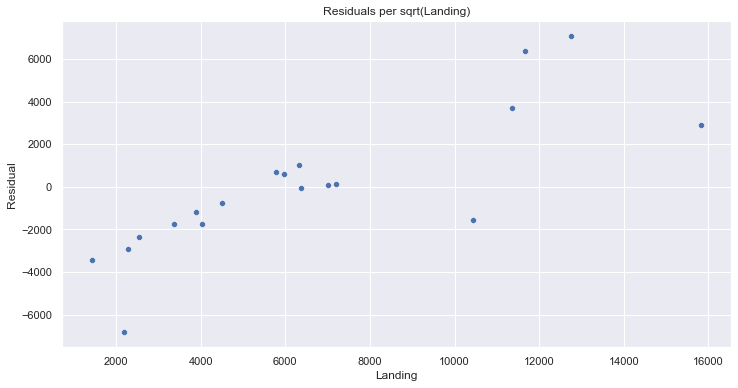

In [22]:
# Sqrting my landings
sum_landings['Landings'] = np.sqrt(sum_landings[['Landings']].sum(axis=1))

# Updating the model
lr = linear_model.LinearRegression()
X = sum_landings[['coastline','population']]
Y = sum_landings['Landings']
lr.fit(X,Y)

intercept=lr.intercept_
coefficients=lr.coef_

# Plotting the residuals
sum_landings['residual'] = sum_landings['Landings'] - ((coefficients[0]*sum_landings['coastline']) + (coefficients[1]*sum_landings['population']) + intercept)

# Plot the residuals
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Landings", y="residual", data=sum_landings)
plt.title("Residuals per sqrt(Landing)")
plt.xlabel("Landing")
plt.ylabel("Residual")
plt.show()

This is a lot nicer! The residuals range from -3 to 3 (constant variance) and they are pretty randomly distributed over the midline!

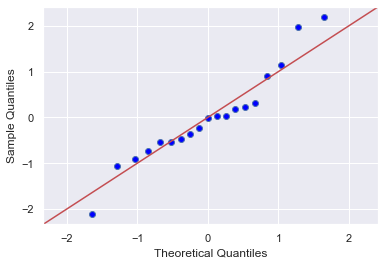

In [23]:
sm.qqplot(data=sum_landings['residual'], fit=True, line="45")
plt.show()

These residuals seem to be normally distributed too. Which is great! Now that all our assumptions are met, we can confidently say that our model is valid. Now let's calculate the R^2 statistic to see how well our model explains landings.

In [24]:
lr = linear_model.LinearRegression()
X = sum_landings[['coastline','population']]
Y = sum_landings['Landings']
lr.fit(X,Y)

# Calculating R^2 and adj. R^2
y_pred = lr.predict(X)

R2 = r2_score(sum_landings.Landings, y_pred)
print("R^2: " + str(R2))

# Sample size & # independent variables
n = len(sum_landings['Landings'])
p = 2
AdjR2 = 1-(1-R2)*(n-1)/(n-p-1)
print("Adj. R^2: " + str(AdjR2))

R^2: 0.3326729011413553
Adj. R^2: 0.24925701378402465


We yielded an R^2 value of 0.33, which is decent, but could be better. We can say with some confidence that the length of a countries coast and the size of their population play significant roles in the amount of fish they catch. You may also notice we got an adjusted R^2 of .25, this is just our original R^2 value with factors accounting for the variables we used. As variables increase the adjusted R^2 will fluxuate depending on how good the predictors are. Since I want the best fit possible, I want to avoid variables that don't add much to my model and only include those that have a high influence on landings. Since population didn't have a very large slope in our regression equation, let's try to predict landings without it. This time I'll only use coast lines to predict landings. 

In [25]:
X = sum_landings[['coastline']]
Y = sum_landings['Landings']
lr.fit(X,Y)

# Calculating R^2 and adj. R^2
y_pred = lr.predict(X)

R2 = r2_score(sum_landings.Landings, y_pred)
print("R^2: " + str(R2))

# Sample size & # independent variables
n = len(sum_landings['Landings'])
p = 1
AdjR2 = 1-(1-R2)*(n-1)/(n-p-1)
print("Adj. R^2: " + str(AdjR2))

R^2: 0.27849743953565964
Adj. R^2: 0.23605611244952196


It looks like population actually does have a statistically significant impact on landings, although it's not too large. From these two tests I can confidently include population in my model. If I wanted a better model, I might have tried to include other parameters like fishing revenue per country or fish consumed per capita. But I'd have to pay attention to my adjusted R^2 value to be sure that I'm not overfitting the data.

# Conclusion
In this data science tutorial, I set out to analyze fishing statistics in the North East Atlantic. Although it may seem boring and tedious at times, it is extremely important that we find trends and analyze this data in order to ensure future generations have a sustainable global ecosystem. In my data analysis, we saw a huge spike in landings over time, hopefully this is just due to better reporting of the data, but I can't be so sure. We also found that populated countries with large coastlines caught the most fish. Perhaps this means countries like Norway should be leading the global effort in fish conservation, since they rely so heavily on their yearly landings for income and sustenance.

More info on overfishing can be found [here](https://en.wikipedia.org/wiki/Overfishing)

Thanks for reading!